In [1]:
import pandas as pd
import numpy as np
names=["id","workId","reviewId","workName","postTime","episodesSeen","author","peopleFoundUseful","overallRating","storyRating","animationRating","soundRating","characterRating","enjoymentRating","review"]
df=pd.read_csv('animeReviewsOrderByTime.txt',header=None,names=names,sep=',',index_col=False)
df.iloc[0:6,:]

D:\Anaconda\envs\learn\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


id  workId  reviewId                           workName  \
0   8121       1         1                       Cowboy_Bebop   
1  63480     856         9                      Utawarerumono   
2   8452     263        10                     Hajime_no_Ippo   
3  66544     129        11               Gensoumaden_Saiyuuki   
4  55936     210        12                            Ranma_½   
5  22039     486        13  Kino_no_Tabi__The_Beautiful_World   

              postTime episodesSeen         author  peopleFoundUseful  \
0  2006-11-07 18:34:00           26          Xinil                162   
1  2006-11-08 00:24:00           26        Crystal                218   
2  2006-11-08 14:39:00           76          Xinil                827   
3  2006-11-09 05:22:00           50         Chelle                 69   
4  2006-11-09 16:48:00          161  running_lemon                 40   
5  2006-11-10 06:43:00           13         Chelle                104   

   overallRating  storyRating  animationRating  soundRating  characterRating  \
0             10            8               10           10               10   
1              8            8                7            7                9   
2             10           10                9            9               10   
3              9            8                6            7               10   
4              7            6                8            8                8   
5              9            9                9            8                9   

   enjoymentRating                                             review  
0               10  Cowboy Bebop is an episodic series. By episodi...  
1                8  Utawarerumono manages to be one of those harem...  
2               10  First, let me say that I\\'m not a fan of boxi...  
3                9  Saiyuki is one of those animes that just grabs...  
4                7  A comedy/romance based on the manga by Rumiko ...  
5                9  What do you say about an anime that is just ab...

In [2]:
df_cleaned=df.loc[:,['workId','workName','review']]

In [3]:
count=df_cleaned.groupby('workId').count().sort_values(by='workName',ascending=False)
order=count.index

In [4]:
df_main=df_cleaned.loc[df_cleaned['workId'].isin(order[0:200]),:]
df_main

workId                workName  \
0            1            Cowboy_Bebop   
12         226              Elfen_Lied   
17         101                     Air   
26         205        Samurai_Champloo   
30         853  Ouran_Koukou_Host_Club   
...        ...                     ...   
135187   37779   Yakusoku_no_Neverland   
135190   22319             Tokyo_Ghoul   
135193   16498      Shingeki_no_Kyojin   
135194   23755       Nanatsu_no_Taizai   
135197       1            Cowboy_Bebop   

                                                   review  
0       Cowboy Bebop is an episodic series. By episodi...  
12      Elfen Lied is something else. Just watching th...  
17      If you'd like to see my full review than leave...  
26      Samurai Champloo is the latest work from Write...  
30      Looking for a show to laugh your ass off? Look...  
...                                                   ...  
135187  Story: For what's it's worth. Yakusoku no Neve...  
135190  A lot of users seem to dislike this anime for ...  
135193  I don't see how this show ended up in top 2 mo...  
135194  Seven Deadly Sins is a shonen anime/manga with...  
135197  [review without spoilers]Cowboy Bebop, a true ...  

[51058 rows x 3 columns]

In [5]:
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords


stemmer = SnowballStemmer("english")

def MY_STEMMER(text):
    s = '*\/:?"<>|'
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            a = re.findall('[a-zA-Z0-9]+',token,re.S)
            token="".join(a)
            filtered_tokens.append(token)

    #exclude stopwords from stemmed words
    stems = [stemmer.stem(t) for t in filtered_tokens if t not in stopwords]

    return stems

reviews = df_main['review']

stopwords = stopwords.words('english')

MyCV=CountVectorizer(input='content',
                        analyzer = 'word',
                        min_df=2,
                        max_features=6000,
                        ##stop_words=["and", "or", "but"],
                        #token_pattern='(?u)[a-zA-Z]+',
                        #token_pattern=pattern,
                        tokenizer=MY_STEMMER,
                        #strip_accents = 'unicode', 
                        lowercase = True
                        )

MyCV1=TfidfVectorizer(input='content',
                        analyzer = 'word',
                        min_df=2,
                        max_features=6000,
                        ##stop_words=["and", "or", "but"],
                        #token_pattern='(?u)[a-zA-Z]+',
                        #token_pattern=pattern,
                        tokenizer=MY_STEMMER,
                        #strip_accents = 'unicode', 
                        lowercase = True
                        )

reviews_converted=np.char.encode(reviews.tolist(), encoding='utf-8')
print("Convertion Completed")
My_DTM = MyCV.fit_transform(reviews_converted)

My_DTM1 = MyCV1.fit_transform(reviews_converted)
print("DTM Completed")

Convertion Completed
DTM Completed


In [6]:
MyColumnNames = MyCV.get_feature_names()

My_DF=pd.DataFrame(My_DTM.toarray(),columns=MyColumnNames)

MyColumnNames1 = MyCV1.get_feature_names()

My_DF1=pd.DataFrame(My_DTM1.toarray(),columns=MyColumnNames1)

In [8]:
colSum = np.sum(My_DF, axis=0)


In [9]:
import wordcloud
w=wordcloud.WordCloud(background_color="white")

dic=dict(zip(MyColumnNames,colSum))
w.generate_from_frequencies(dic)
w.to_file('''review_wordcloud.png''')

In [117]:
rowSum = np.sum(My_DF,axis=1)

for i in range(My_DF.shape[0]):
    if rowSum[i]!=0:
        My_DF.iloc[i,:]=My_DF.iloc[i,:]/rowSum[i]
print('FreqComputation Completed')
My_DF_rec=My_DF

rowSum1 = np.sum(My_DF1,axis=1)

for i in range(My_DF1.shape[0]):
    if rowSum1[i]!=0:
        My_DF1.iloc[i,:]=My_DF1.iloc[i,:]/rowSum1[i]
print('FreqComputation Completed')
My_DF1_rec=My_DF1

FreqComputation Completed
FreqComputation Completed


In [118]:
My_DF=My_DF_rec
df_main.index=np.arange(df_main.shape[0])
My_DF['Label']=df_main['workId']
drop_lines=np.arange(My_DF.shape[0])[rowSum==0].tolist()
My_DF=My_DF.drop(drop_lines,axis=0)

My_DF1=My_DF1_rec
df_main.index=np.arange(df_main.shape[0])
My_DF1['Label']=df_main['workId']
drop_lines=np.arange(My_DF1.shape[0])[rowSum1==0].tolist()
My_DF1=My_DF1.drop(drop_lines,axis=0)

In [119]:
from sklearn.model_selection import train_test_split
import random as rd
rd.seed(1234)
#####
TrainDF1, TestDF1 = train_test_split(My_DF, test_size=0.2)
TestLabels1=TestDF1['Label']
TestDF1 = TestDF1.drop(["Label"], axis=1)

TrainLabels1=TrainDF1["Label"]
TrainDF1 = TrainDF1.drop(["Label"], axis=1)
#####
TrainDF2, TestDF2 = train_test_split(My_DF, test_size=0.2)
TestLabels2=TestDF2['Label']
TestDF2 = TestDF2.drop(["Label"], axis=1)

TrainLabels2=TrainDF2["Label"]
TrainDF2 = TrainDF2.drop(["Label"], axis=1)
#####
TrainDF3, TestDF3 = train_test_split(My_DF1, test_size=0.2)
TestLabels3=TestDF3['Label']
TestDF3 = TestDF3.drop(["Label"], axis=1)

TrainLabels3=TrainDF3["Label"]
TrainDF3 = TrainDF3.drop(["Label"], axis=1)
#####
TrainDF4, TestDF4 = train_test_split(My_DF1, test_size=0.2)
TestLabels4=TestDF4['Label']
TestDF4 = TestDF4.drop(["Label"], axis=1)

TrainLabels4=TrainDF4["Label"]
TrainDF4 = TrainDF4.drop(["Label"], axis=1)

In [120]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
import graphviz 
from sklearn.metrics import confusion_matrix

EnDT1=DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                            splitter='best',  ## or "random" or "best"
                            max_depth=1000, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            class_weight=None)

GiDT1=DecisionTreeClassifier(criterion='gini', ##"entropy" or "gini"
                            splitter='best',  ## or "random" or "best"
                            max_depth=1000, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            class_weight=None)

EnDT2=DecisionTreeClassifier(criterion='entropy', ##"entropy" or "gini"
                            splitter='best',  ## or "random" or "best"
                            max_depth=1000, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            class_weight=None)

GiDT2=DecisionTreeClassifier(criterion='gini', ##"entropy" or "gini"
                            splitter='best',  ## or "random" or "best"
                            max_depth=1000, 
                            min_samples_split=2, 
                            min_samples_leaf=1, 
                            min_weight_fraction_leaf=0.0, 
                            max_features=None, 
                            random_state=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.0, 
                            min_impurity_split=None, 
                            class_weight=None)



In [121]:
EnDT1.fit(TrainDF1,TrainLabels1)
print('Fit completed 1')
GiDT1.fit(TrainDF2,TrainLabels2)
print('Fit completed 2')
EnDT2.fit(TrainDF3,TrainLabels3)
print('Fit completed 3')
GiDT2.fit(TrainDF4,TrainLabels4)
print('Fit completed 4')

Fit completed 1
Fit completed 2
Fit completed 3
Fit completed 4


In [133]:
My_DF.shape

(51039, 6001)

png completed


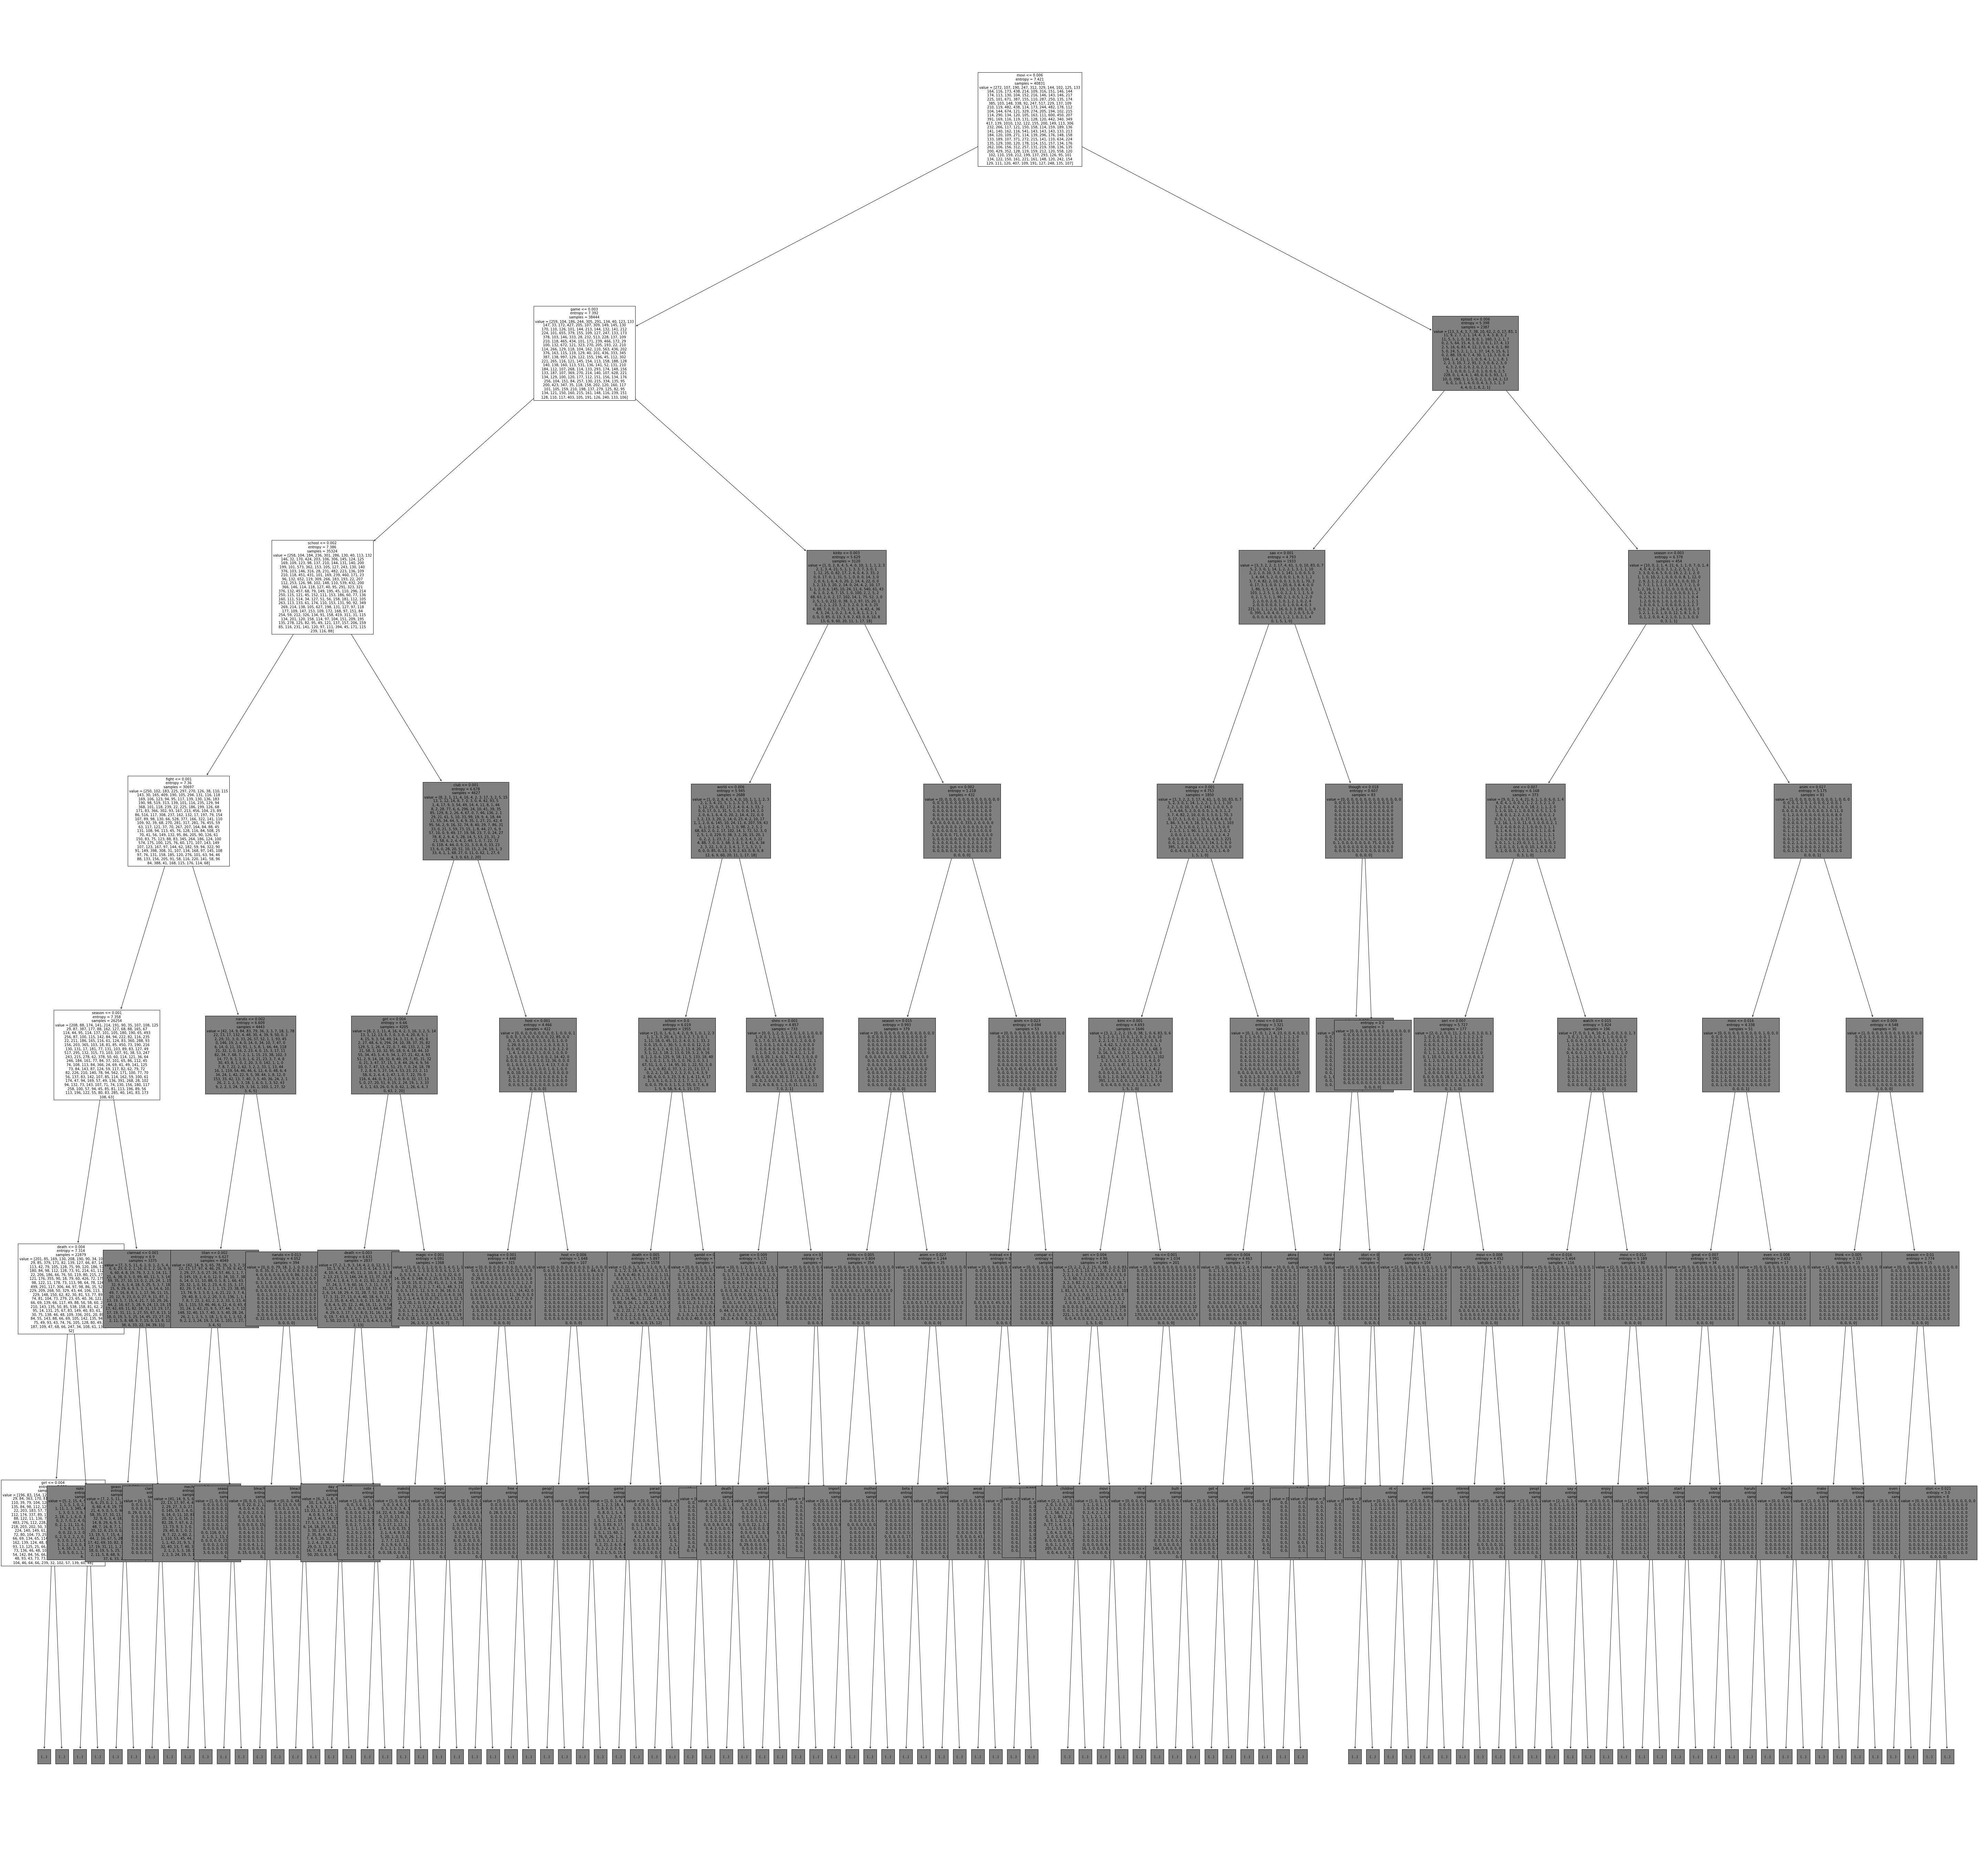

In [134]:
from matplotlib.pyplot import figure
width=100
height=100
plt.rcParams['figure.figsize'] = width, height
tree.plot_tree(EnDT1, max_depth=6, fontsize=10, feature_names=My_DF.columns[0:6000])

plt.savefig('Count_Entropy.png')
print('png completed')

png completed


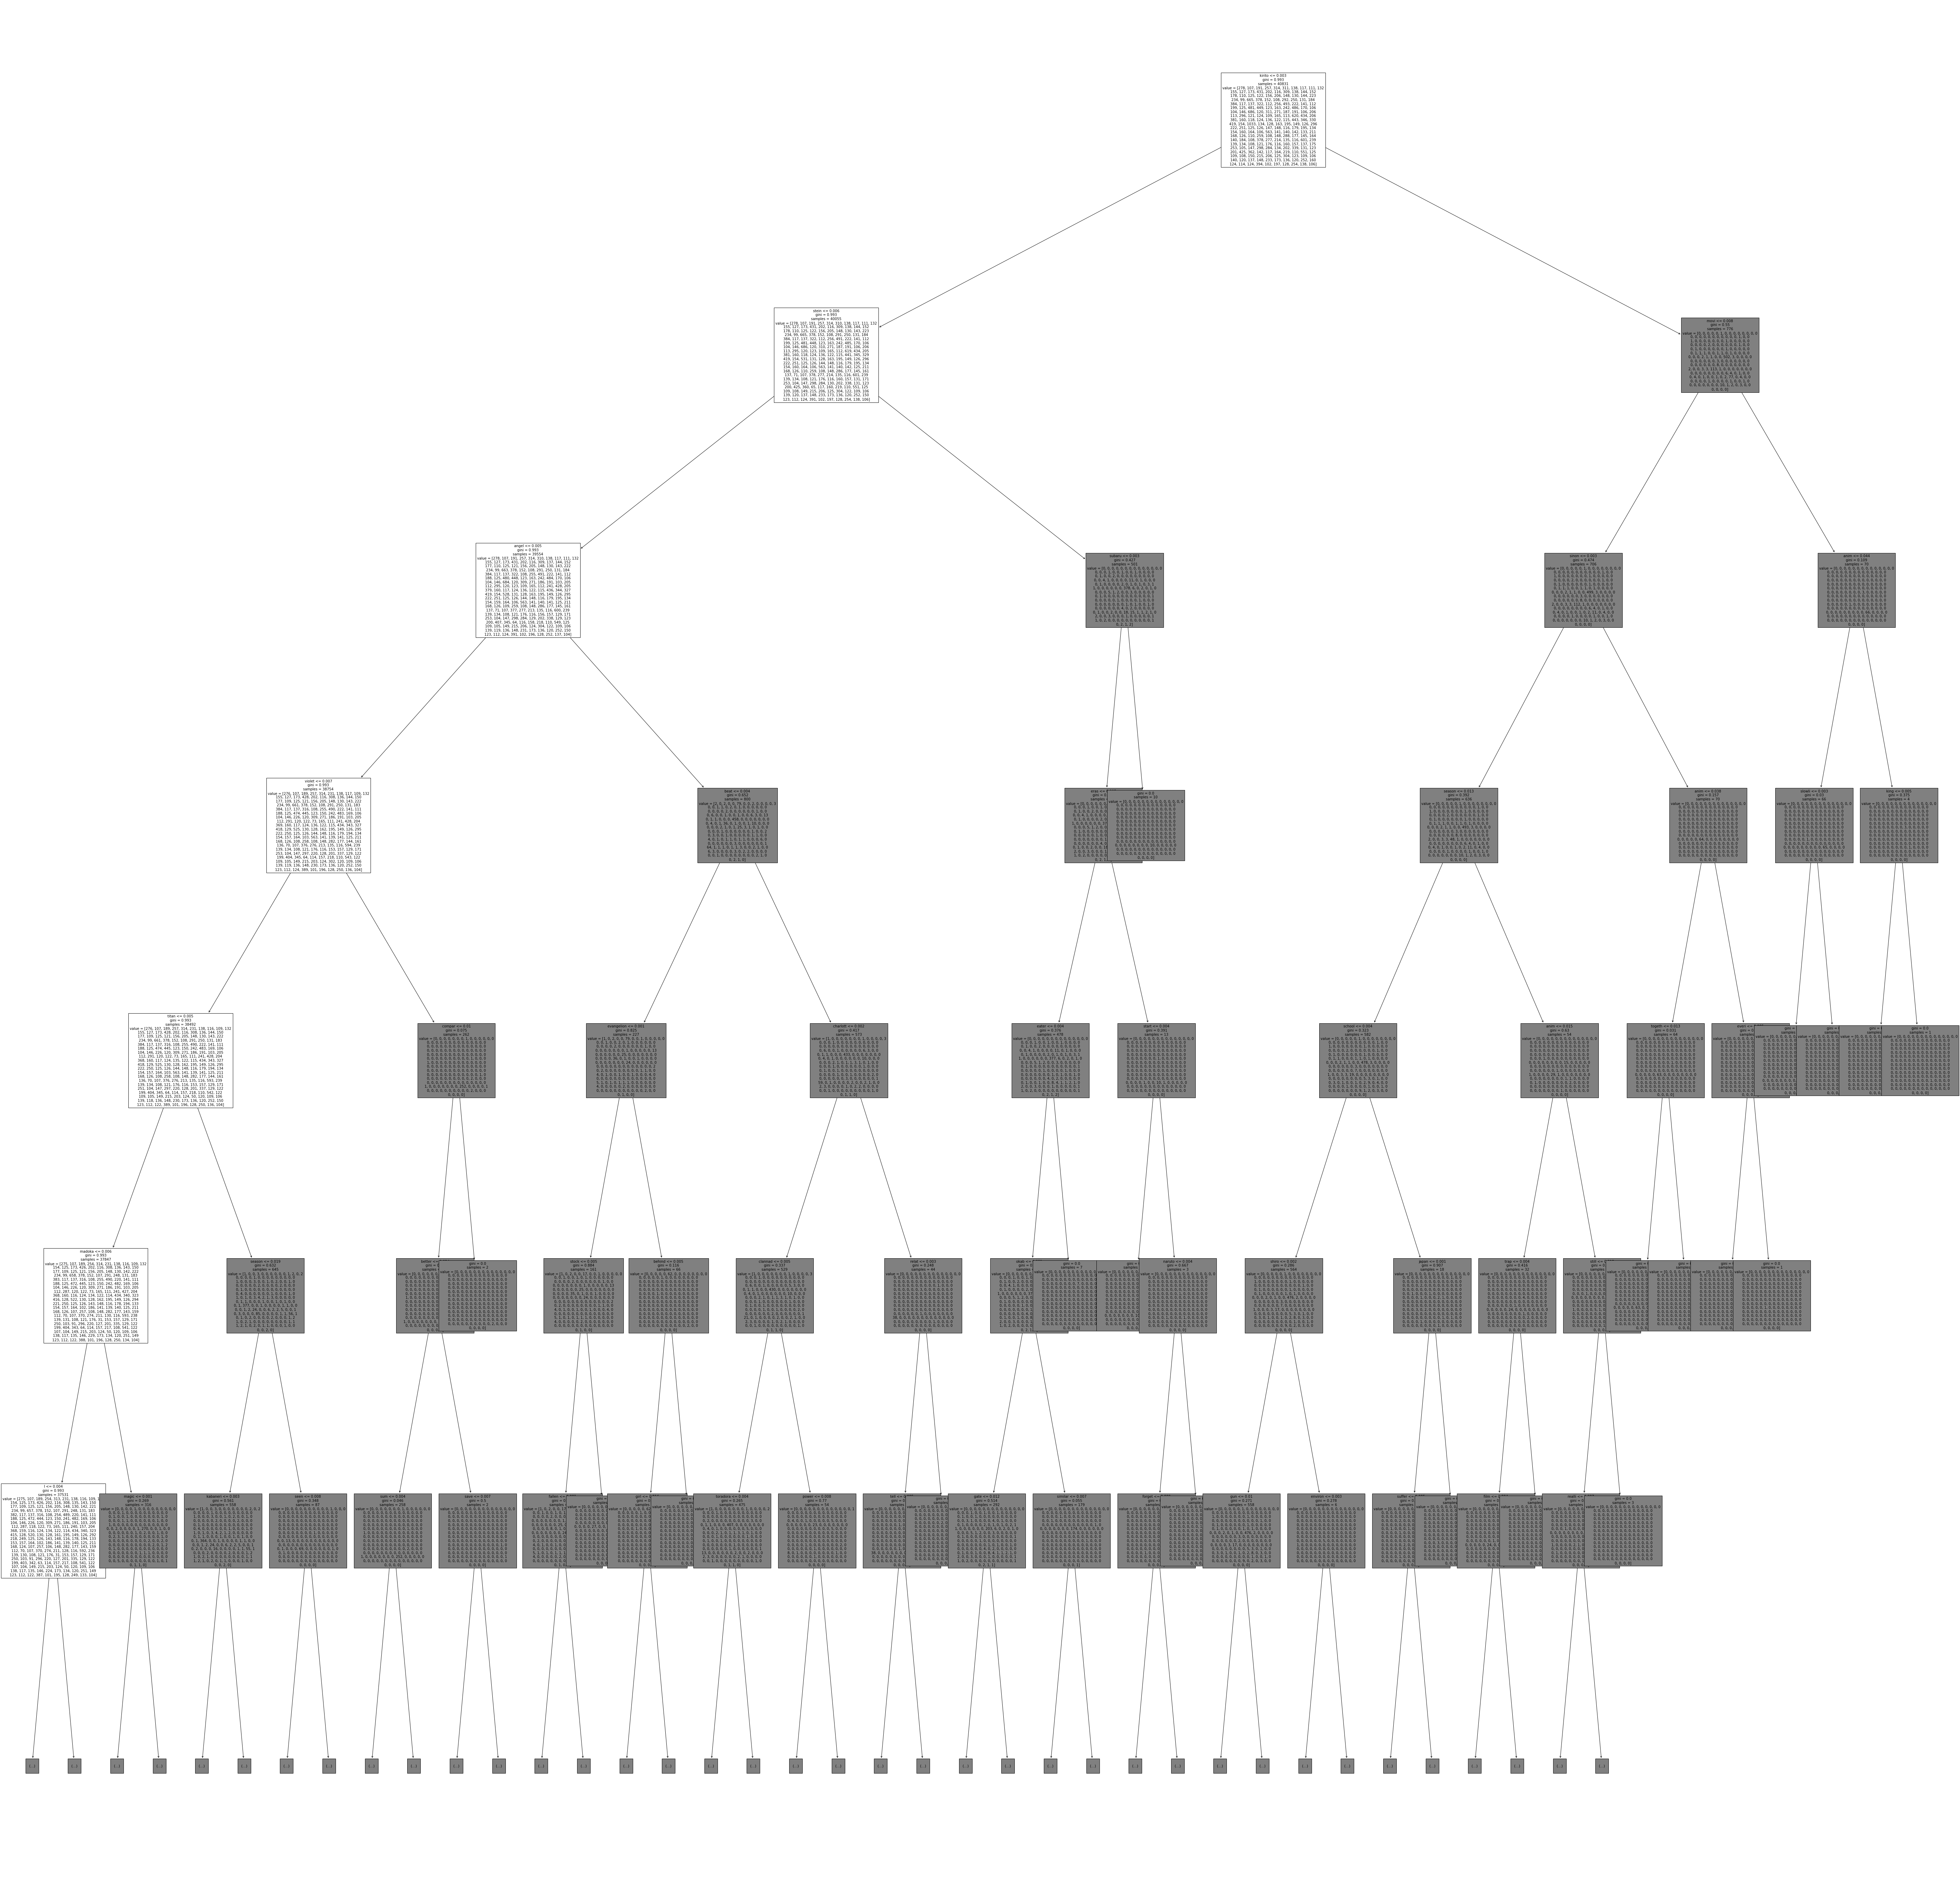

In [135]:
tree.plot_tree(GiDT1, max_depth=6, fontsize=10, feature_names=My_DF.columns[0:6000])

plt.savefig('Count_Gini.png')
print('png completed')

In [137]:
My_DF1.shape

(51039, 6001)

png completed


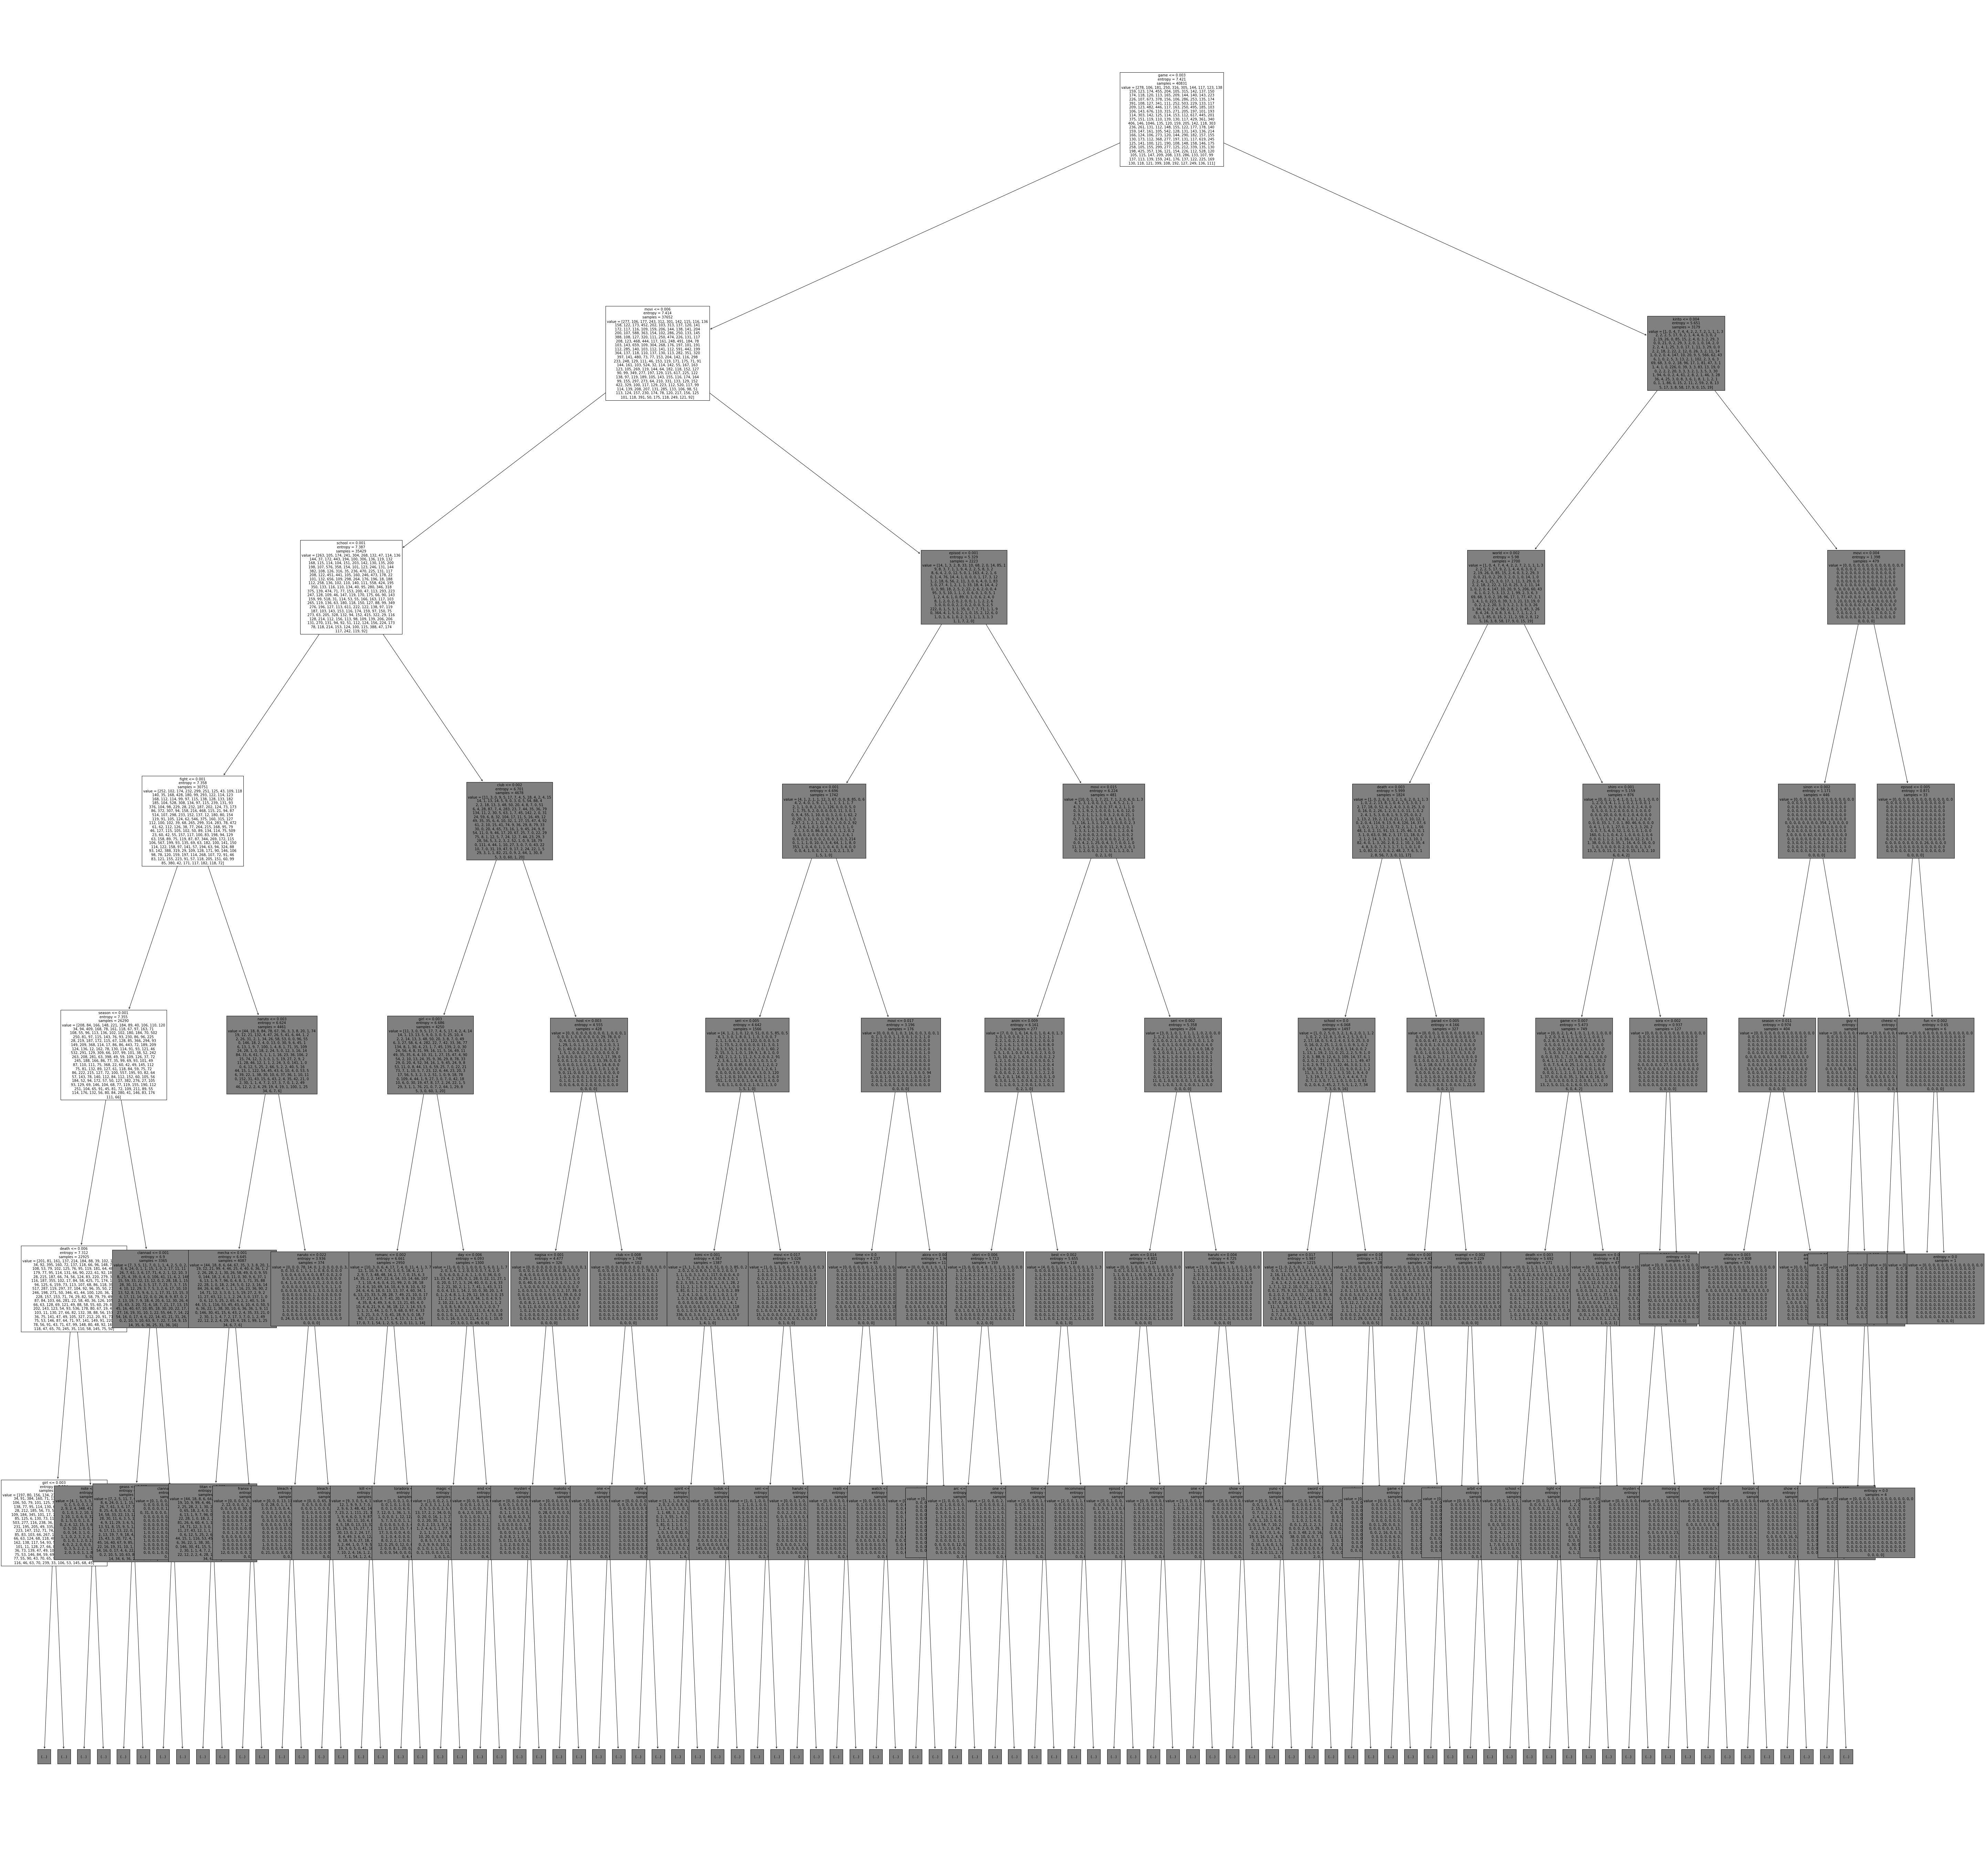

In [136]:
tree.plot_tree(EnDT2, max_depth=6, fontsize=10, feature_names=My_DF1.columns[0:6000])


plt.savefig('Tfidf_Entropy.png')
print('png completed')

png completed


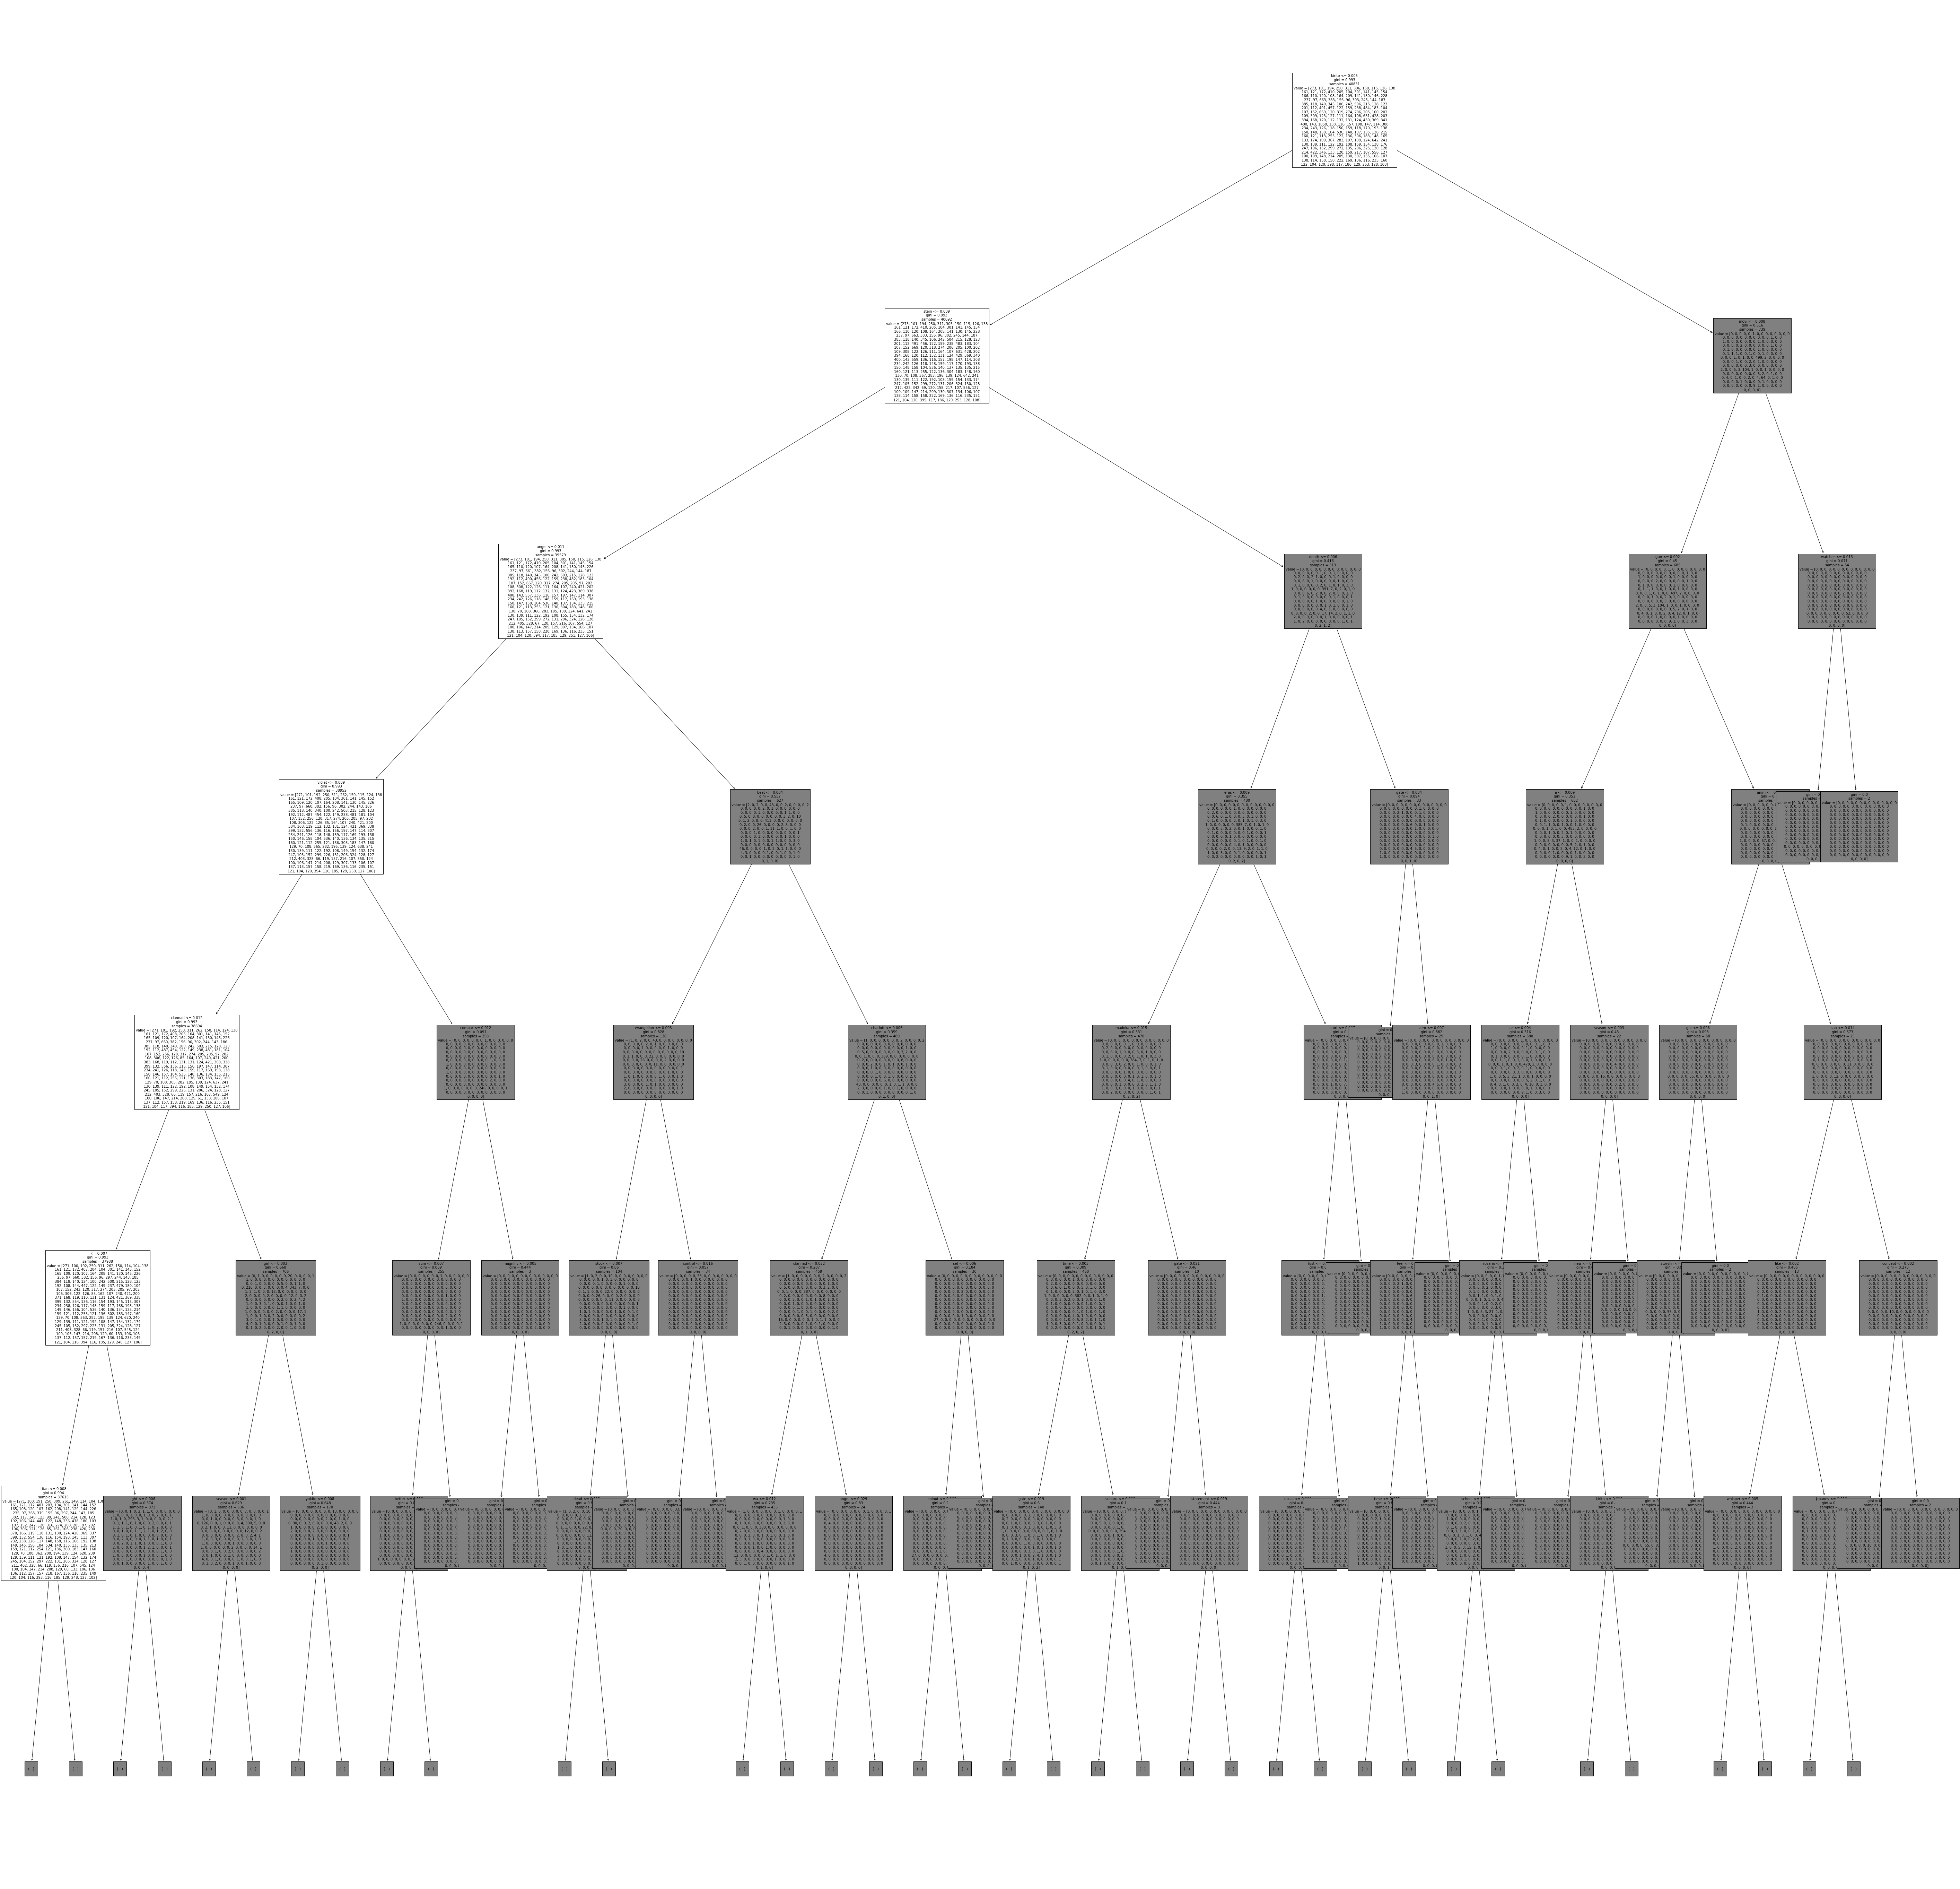

In [138]:
tree.plot_tree(GiDT2, max_depth=6, fontsize=10, feature_names=My_DF1.columns[0:6000])

plt.savefig('Tfidf_Gini.png')
print('png completed')

In [139]:
import pydot
import graphviz 
dot_data = tree.export_graphviz(EnDT1, out_file=None,
                    ## The following creates TrainDF.columns for each
                    ## which are the feature names.
                      feature_names=TrainDF1.columns,  
                      #class_names=MyDT.class_names,  
                      filled=True, rounded=True,  
                      special_characters=True,
                               max_depth=6)   

graph = graphviz.Source(dot_data,format='png')
graph.render('CE_graph',format='png')

'CE_graph.png'

In [140]:
dot_data = tree.export_graphviz(GiDT1, out_file=None,
                    ## The following creates TrainDF.columns for each
                    ## which are the feature names.
                      feature_names=TrainDF2.columns,  
                      #class_names=MyDT.class_names,  
                      filled=True, rounded=True,  
                      special_characters=True,
                               max_depth=6)   

graph = graphviz.Source(dot_data,format='png')
graph.render('CG_graph',format='png')

'CG_graph.png'

In [141]:
dot_data = tree.export_graphviz(EnDT2, out_file=None,
                    ## The following creates TrainDF.columns for each
                    ## which are the feature names.
                      feature_names=TrainDF3.columns,  
                      #class_names=MyDT.class_names,  
                      filled=True, rounded=True,  
                      special_characters=True,
                               max_depth=6)   

graph = graphviz.Source(dot_data,format='png')
graph.render('TE_graph',format='png')

'TE_graph.png'

In [142]:
dot_data = tree.export_graphviz(GiDT2, out_file=None,
                    ## The following creates TrainDF.columns for each
                    ## which are the feature names.
                      feature_names=TrainDF4.columns,  
                      #class_names=MyDT.class_names,  
                      filled=True, rounded=True,  
                      special_characters=True,
                               max_depth=6)   

graph = graphviz.Source(dot_data,format='png')
graph.render('TG_graph',format='png')

'TG_graph.png'

In [143]:
EnDT_pred1=EnDT1.predict(TestDF1)
bn_matrix1 = confusion_matrix(TestLabels1, EnDT_pred1)
print("\nThe confusion matrix is:")
print(bn_matrix1)

feature_names1=TrainDF1.columns
FeatureImp1=EnDT1.feature_importances_   
indices1 = np.argsort(FeatureImp1)[::-1]
## print out the important features.....
for f in range(TrainDF1.shape[1]):
    if FeatureImp1[indices1[f]] > 0:
        print("%d. feature %d (%f)" % (f + 1, indices1[f], FeatureImp1[indices1[f]]))
        print ("feature name: ", feature_names1[indices1[f]])


The confusion matrix is:
[[27  3  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  6 ...  0  1  0]
 ...
 [ 0  0  0 ...  3  0  1]
 [ 0  1  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  0]]
1. feature 284 (0.039782)
feature name:  anim
2. feature 853 (0.027917)
feature name:  charact
3. feature 5034 (0.026561)
feature name:  stori
4. feature 5777 (0.026546)
feature name:  watch
5. feature 3626 (0.023857)
feature name:  nt
6. feature 2117 (0.022697)
feature name:  game
7. feature 3451 (0.022483)
feature name:  movi
8. feature 3069 (0.022113)
feature name:  like
9. feature 1737 (0.020822)
feature name:  episod
10. feature 2180 (0.019547)
feature name:  girl
11. feature 3678 (0.018356)
feature name:  one
12. feature 4549 (0.018197)
feature name:  school
13. feature 4572 (0.017070)
feature name:  season
14. feature 1951 (0.014613)
feature name:  fight
15. feature 1967 (0.014167)
feature name:  first
16. feature 1302 (0.013500)
feature name:  death
17. feature 5356 (0.013092)
feature name:  time
18

feature name:  express
1080. feature 1470 (0.000034)
feature name:  dislik
1081. feature 1980 (0.000034)
feature name:  flat
1082. feature 365 (0.000034)
feature name:  area
1083. feature 2271 (0.000033)
feature name:  grip
1084. feature 302 (0.000033)
feature name:  anohana
1085. feature 2835 (0.000033)
feature name:  kakegurui
1086. feature 4088 (0.000033)
feature name:  proper
1087. feature 4991 (0.000033)
feature name:  standard
1088. feature 2659 (0.000033)
feature name:  initi
1089. feature 4408 (0.000033)
feature name:  rival
1090. feature 1025 (0.000033)
feature name:  combin
1091. feature 3160 (0.000033)
feature name:  mafia
1092. feature 1589 (0.000033)
feature name:  earli
1093. feature 4153 (0.000033)
feature name:  quirk
1094. feature 5226 (0.000033)
feature name:  tale
1095. feature 5993 (0.000033)
feature name:  zankyou
1096. feature 4066 (0.000033)
feature name:  produc
1097. feature 5095 (0.000033)
feature name:  subject
1098. feature 2428 (0.000033)
feature name:  hig

feature name:  favor
2168. feature 2246 (0.000009)
feature name:  grant
2169. feature 899 (0.000009)
feature name:  chika
2170. feature 3596 (0.000009)
feature name:  nonexist
2171. feature 155 (0.000009)
feature name:  aforement
2172. feature 1485 (0.000009)
feature name:  distant
2173. feature 456 (0.000009)
feature name:  await
2174. feature 4238 (0.000009)
feature name:  recognit
2175. feature 1488 (0.000009)
feature name:  distinguish
2176. feature 1491 (0.000009)
feature name:  distress
2177. feature 3659 (0.000009)
feature name:  ofcours
2178. feature 4714 (0.000009)
feature name:  shokugeki
2179. feature 1636 (0.000009)
feature name:  eleg
2180. feature 4249 (0.000009)
feature name:  redeem
2181. feature 4251 (0.000009)
feature name:  redo
2182. feature 5760 (0.000009)
feature name:  wannab
2183. feature 119 (0.000009)
feature name:  activ
2184. feature 2085 (0.000009)
feature name:  fullest
2185. feature 114 (0.000009)
feature name:  acquir
2186. feature 1633 (0.000009)
featur

In [123]:
GiDT_pred1=GiDT1.predict(TestDF2)
bn_matrix2 = confusion_matrix(TestLabels2, GiDT_pred1)
print("\nThe confusion matrix is:")
print(bn_matrix2)

feature_names2=TrainDF2.columns
FeatureImp2=GiDT1.feature_importances_   
indices2 = np.argsort(FeatureImp2)[::-1]
## print out the important features.....
for f in range(TrainDF2.shape[1]):
    if FeatureImp2[indices2[f]] > 0:
        print("%d. feature %d (%f)" % (f + 1, indices2[f], FeatureImp2[indices2[f]]))
        print ("feature name: ", feature_names2[indices2[f]])


The confusion matrix is:
[[55  0  0 ...  1  0  0]
 [ 1 11  0 ...  0  0  0]
 [ 0  0 28 ...  0  1  0]
 ...
 [ 0  0  0 ... 35  0  0]
 [ 0  0  0 ...  0 14  0]
 [ 1  0  0 ...  0  1 12]]
1. feature 2898 (0.008281)
feature name:  kirito
2. feature 5013 (0.007074)
feature name:  stein
3. feature 4572 (0.006961)
feature name:  season
4. feature 278 (0.006775)
feature name:  angel
5. feature 284 (0.006514)
feature name:  anim
6. feature 955 (0.006275)
feature name:  clannad
7. feature 5371 (0.006097)
feature name:  titan
8. feature 5717 (0.006065)
feature name:  violet
9. feature 3157 (0.005989)
feature name:  madoka
10. feature 3451 (0.005950)
feature name:  movi
11. feature 2970 (0.005674)
feature name:  l
12. feature 3516 (0.005057)
feature name:  naruto
13. feature 713 (0.005034)
feature name:  brotherhood
14. feature 5413 (0.004936)
feature name:  toradora
15. feature 2141 (0.004815)
feature name:  geass
16. feature 188 (0.004810)
feature name:  akam
17. feature 1642 (0.004701)
feature nam

feature name:  posit
949. feature 962 (0.000175)
feature name:  classic
950. feature 3637 (0.000175)
feature name:  object
951. feature 1057 (0.000175)
feature name:  complaint
952. feature 1245 (0.000175)
feature name:  current
953. feature 3382 (0.000174)
feature name:  miss
954. feature 4989 (0.000174)
feature name:  stand
955. feature 4610 (0.000173)
feature name:  senki
956. feature 768 (0.000173)
feature name:  calligraphi
957. feature 3834 (0.000173)
feature name:  particular
958. feature 1970 (0.000173)
feature name:  fit
959. feature 3948 (0.000173)
feature name:  pleas
960. feature 4201 (0.000173)
feature name:  reach
961. feature 4278 (0.000173)
feature name:  rel
962. feature 2362 (0.000172)
feature name:  haruko
963. feature 133 (0.000172)
feature name:  adlet
964. feature 2585 (0.000172)
feature name:  imouto
965. feature 2764 (0.000172)
feature name:  izaya
966. feature 4715 (0.000172)
feature name:  shonen
967. feature 1659 (0.000171)
feature name:  emi
968. feature 479

2115. feature 1047 (0.000033)
feature name:  comparison
2116. feature 4045 (0.000033)
feature name:  primarili
2117. feature 5878 (0.000033)
feature name:  wizard
2118. feature 1113 (0.000033)
feature name:  contact
2119. feature 3951 (0.000033)
feature name:  plenti
2120. feature 4965 (0.000033)
feature name:  spout
2121. feature 4065 (0.000033)
feature name:  prodigi
2122. feature 105 (0.000033)
feature name:  accur
2123. feature 2056 (0.000032)
feature name:  fragment
2124. feature 1043 (0.000031)
feature name:  como
2125. feature 2785 (0.000030)
feature name:  jesus
2126. feature 392 (0.000029)
feature name:  artsound
2127. feature 4758 (0.000029)
feature name:  sigh
2128. feature 1277 (0.000028)
feature name:  dare
2129. feature 2103 (0.000028)
feature name:  futur
2130. feature 5436 (0.000027)
feature name:  tragic
2131. feature 5758 (0.000026)
feature name:  wan
2132. feature 629 (0.000026)
feature name:  blunt
2133. feature 83 (0.000026)
feature name:  abstract
2134. feature 68

In [124]:
EnDT_pred2=EnDT2.predict(TestDF3)
bn_matrix3 = confusion_matrix(TestLabels3, EnDT_pred2)
print("\nThe confusion matrix is:")
print(bn_matrix3)

feature_names3=TrainDF3.columns
FeatureImp3=EnDT2.feature_importances_   
indices3 = np.argsort(FeatureImp3)[::-1]
## print out the important features.....
for f in range(TrainDF3.shape[1]):
    if FeatureImp3[indices3[f]] > 0:
        print("%d. feature %d (%f)" % (f + 1, indices3[f], FeatureImp3[indices3[f]]))
        print ("feature name: ", feature_names3[indices3[f]])


The confusion matrix is:
[[27  0  1 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]
 [ 0  0 10 ...  0  1  0]
 ...
 [ 0  0  0 ...  4  0  0]
 [ 0  0  0 ...  0  1  0]
 [ 0  0  0 ...  0  0  0]]
1. feature 284 (0.047205)
feature name:  anim
2. feature 853 (0.027930)
feature name:  charact
3. feature 5034 (0.026172)
feature name:  stori
4. feature 5777 (0.025683)
feature name:  watch
5. feature 2117 (0.024475)
feature name:  game
6. feature 3451 (0.022220)
feature name:  movi
7. feature 3626 (0.021976)
feature name:  nt
8. feature 3678 (0.021863)
feature name:  one
9. feature 1737 (0.019490)
feature name:  episod
10. feature 3069 (0.019394)
feature name:  like
11. feature 4549 (0.019038)
feature name:  school
12. feature 2180 (0.018123)
feature name:  girl
13. feature 4572 (0.016637)
feature name:  season
14. feature 4731 (0.015151)
feature name:  show
15. feature 1951 (0.014012)
feature name:  fight
16. feature 5893 (0.013797)
feature name:  world
17. feature 3127 (0.012936)
feature name:  love
18.

1132. feature 4937 (0.000031)
feature name:  spent
1133. feature 3729 (0.000031)
feature name:  ost
1134. feature 1474 (0.000031)
feature name:  display
1135. feature 5095 (0.000031)
feature name:  subject
1136. feature 5480 (0.000031)
feature name:  trope
1137. feature 5286 (0.000031)
feature name:  terribl
1138. feature 5431 (0.000031)
feature name:  track
1139. feature 918 (0.000031)
feature name:  choos
1140. feature 2679 (0.000031)
feature name:  instanc
1141. feature 5828 (0.000031)
feature name:  whenev
1142. feature 2583 (0.000031)
feature name:  immort
1143. feature 2710 (0.000031)
feature name:  intro
1144. feature 1164 (0.000031)
feature name:  cough
1145. feature 4560 (0.000031)
feature name:  screen
1146. feature 4459 (0.000031)
feature name:  rush
1147. feature 3281 (0.000031)
feature name:  meh
1148. feature 5620 (0.000030)
feature name:  unrequit
1149. feature 389 (0.000030)
feature name:  artist
1150. feature 5396 (0.000030)
feature name:  tomorrow
1151. feature 4248 (

feature name:  squad
2299. feature 2198 (0.000009)
feature name:  glue
2300. feature 5230 (0.000009)
feature name:  tamaki
2301. feature 793 (0.000009)
feature name:  carefre
2302. feature 4185 (0.000009)
feature name:  rant
2303. feature 3128 (0.000009)
feature name:  loveabl
2304. feature 1013 (0.000009)
feature name:  cold
2305. feature 2089 (0.000009)
feature name:  function
2306. feature 3124 (0.000009)
feature name:  loud
2307. feature 4012 (0.000009)
feature name:  predica
2308. feature 2096 (0.000009)
feature name:  funniest
2309. feature 4030 (0.000009)
feature name:  presum
2310. feature 4043 (0.000009)
feature name:  priestess
2311. feature 4061 (0.000009)
feature name:  problemat
2312. feature 4063 (0.000009)
feature name:  process
2313. feature 4089 (0.000009)
feature name:  properti
2314. feature 71 (0.000009)
feature name:  a1
2315. feature 4419 (0.000009)
feature name:  rokka
2316. feature 965 (0.000009)
feature name:  classroom
2317. feature 3064 (0.000009)
feature nam

In [125]:
GiDT_pred2=GiDT2.predict(TestDF4)
bn_matrix4 = confusion_matrix(TestLabels4, GiDT_pred2)
print("\nThe confusion matrix is:")
print(bn_matrix4)

feature_names4=TrainDF4.columns
FeatureImp4=GiDT2.feature_importances_   
indices4 = np.argsort(FeatureImp4)[::-1]
## print out the important features.....
for f in range(TrainDF4.shape[1]):
    if FeatureImp4[indices4[f]] > 0:
        print("%d. feature %d (%f)" % (f + 1, indices4[f], FeatureImp4[indices4[f]]))
        print ("feature name: ", feature_names4[indices4[f]])


The confusion matrix is:
[[52  2  0 ...  0  0  0]
 [ 1 21  0 ...  0  0  0]
 [ 0  0 28 ...  0  0  0]
 ...
 [ 0  0  0 ... 31  0  0]
 [ 0  0  0 ...  0 17  0]
 [ 0  0  0 ...  0  0 16]]
1. feature 2898 (0.008521)
feature name:  kirito
2. feature 278 (0.007549)
feature name:  angel
3. feature 5013 (0.007222)
feature name:  stein
4. feature 284 (0.006857)
feature name:  anim
5. feature 955 (0.006570)
feature name:  clannad
6. feature 4572 (0.006117)
feature name:  season
7. feature 5371 (0.006097)
feature name:  titan
8. feature 3157 (0.005948)
feature name:  madoka
9. feature 3451 (0.005845)
feature name:  movi
10. feature 5717 (0.005796)
feature name:  violet
11. feature 2970 (0.005672)
feature name:  l
12. feature 5413 (0.005257)
feature name:  toradora
13. feature 2141 (0.004850)
feature name:  geass
14. feature 3516 (0.004845)
feature name:  naruto
15. feature 188 (0.004731)
feature name:  akam
16. feature 4490 (0.004712)
feature name:  saitama
17. feature 713 (0.004679)
feature name:  

1165. feature 2152 (0.000123)
feature name:  genius
1166. feature 2207 (0.000123)
feature name:  gohan
1167. feature 1050 (0.000122)
feature name:  compel
1168. feature 2235 (0.000122)
feature name:  grade
1169. feature 4624 (0.000122)
feature name:  sequel
1170. feature 200 (0.000122)
feature name:  al
1171. feature 5165 (0.000122)
feature name:  surviv
1172. feature 2921 (0.000122)
feature name:  koe
1173. feature 5019 (0.000122)
feature name:  stereotyp
1174. feature 2865 (0.000122)
feature name:  kayo
1175. feature 3576 (0.000121)
feature name:  night
1176. feature 5504 (0.000121)
feature name:  twelv
1177. feature 1028 (0.000121)
feature name:  comed
1178. feature 5133 (0.000121)
feature name:  summari
1179. feature 905 (0.000121)
feature name:  chill
1180. feature 2724 (0.000121)
feature name:  involv
1181. feature 5402 (0.000120)
feature name:  tone
1182. feature 4048 (0.000120)
feature name:  princess
1183. feature 4636 (0.000120)
feature name:  servant
1184. feature 714 (0.000

feature name:  lol
2332. feature 5375 (0.000025)
feature name:  tl
2333. feature 5492 (0.000025)
feature name:  tsukasa
2334. feature 4611 (0.000025)
feature name:  senpai
2335. feature 2538 (0.000025)
feature name:  hybrid
2336. feature 1530 (0.000025)
feature name:  dr
2337. feature 3206 (0.000025)
feature name:  manipul
2338. feature 5487 (0.000025)
feature name:  trunk
2339. feature 5482 (0.000025)
feature name:  trough
2340. feature 4618 (0.000025)
feature name:  sent
2341. feature 2542 (0.000025)
feature name:  hyperact
2342. feature 769 (0.000025)
feature name:  calm
2343. feature 4625 (0.000025)
feature name:  sequenc
2344. feature 4626 (0.000025)
feature name:  ser
2345. feature 3118 (0.000025)
feature name:  los
2346. feature 5378 (0.000025)
feature name:  todo
2347. feature 2603 (0.000025)
feature name:  inappropri
2348. feature 1524 (0.000025)
feature name:  downhil
2349. feature 1575 (0.000025)
feature name:  dust
2350. feature 2521 (0.000025)
feature name:  huh
2351. feat

In [126]:
accuracy1 = np.sum(bn_matrix1.diagonal())/len(TestDF1)
accuracy1

0.16496865203761754

In [127]:
accuracy2 = np.sum(bn_matrix2.diagonal())/len(TestDF2)
accuracy2

0.5972766457680251

In [128]:
accuracy3 = np.sum(bn_matrix3.diagonal())/len(TestDF3)
accuracy3

0.17231583072100312

In [129]:
accuracy4 = np.sum(bn_matrix4.diagonal())/len(TestDF4)
accuracy4

0.5966888714733543

In [103]:
accuracy=bn_matrix1.diagonal()/np.sum(bn_matrix1,axis=1)
num=np.sum(bn_matrix1,axis=1)
pd.set_option('display.max_rows', 200)
df_preview=pd.DataFrame({'accuracy':accuracy,'num':num})
df_preview

accuracy  num
0    0.347222   72
1    0.000000   28
2    0.019231   52
3    0.379310   58
4    0.060606   66
5    0.176471   85
6    0.085714   35
7    0.312500   32
8    0.000000   25
9    0.000000   27
10   0.021739   46
11   0.560000   25
12   0.184211   38
13   0.270270  111
14   0.000000   51
15   0.000000   31
16   0.287879   66
17   0.033333   30
18   0.027027   37
19   0.069767   43
20   0.055556   36
21   0.030303   33
22   0.000000   39
23   0.130435   23
24   0.080000   50
25   0.408163   49
26   0.024390   41
27   0.000000   30
28   0.000000   32
29   0.019608   51
30   0.019231   52
31   0.000000   38
32   0.586826  167
33   0.222222   81
34   0.024390   41
35   0.041667   24
36   0.281690   71
37   0.431034   58
38   0.000000   37
39   0.048780   41
40   0.153846  104
41   0.200000   30
42   0.107143   28
43   0.238636   88
44   0.000000   27
45   0.321429   56
46   0.286822  129
47   0.238806   67
48   0.031250   32
49   0.066667   30
50   0.018519   54
51   0.000000   36
52   0.360360  111
53   0.093458  107
54   0.090909   33
55   0.000000   35
56   0.036364   55
57   0.134921  126
58   0.200000   35
59   0.320000   25
60   0.000000   23
61   0.052632   38
62   0.291429  175
63   0.000000   34
64   0.085714   70
65   0.044776   67
66   0.033898   59
67   0.019231   52
68   0.461538   26
69   0.070175   57
70   0.030303   33
71   0.151515   66
72   0.088235   34
73   0.000000   32
74   0.148148   27
75   0.000000   43
76   0.133333   30
77   0.520710  169
78   0.598214  112
79   0.000000   44
80   0.119266  109
81   0.138889   36
82   0.000000   38
83   0.040000   25
84   0.057143   35
85   0.228571   35
86   0.000000   30
87   0.055046  109
88   0.056075  107
89   0.218391   87
90   0.212963  108
91   0.108108   37
92   0.346863  271
93   0.200000   40
94   0.085714   35
95   0.000000   39
96   0.358491   53
97   0.405405   37
98   0.064516   31
99   0.065574   61
100  0.016667   60
101  0.016667   60
102  0.000000   31
103  0.100000   30
104  0.051282   39
105  0.027778   36
106  0.000000   21
107  0.000000   35
108  0.212766   47
109  0.105263   19
110  0.023810   42
111  0.054054   37
112  0.000000   38
113  0.043478   23
114  0.241611  149
115  0.147059   34
116  0.031250   32
117  0.162162   37
118  0.179487   39
119  0.048780   41
120  0.024390   41
121  0.000000   35
122  0.000000   24
123  0.375000   72
124  0.031250   32
125  0.000000   40
126  0.386667   75
127  0.000000   35
128  0.360000   25
129  0.285714   35
130  0.050000   40
131  0.194444   36
132  0.366667   30
133  0.346939   98
134  0.192771   83
135  0.000000   53
136  0.085714   35
137  0.055556   36
138  0.198795  166
139  0.000000   60
140  0.000000   29
141  0.000000   35
142  0.086957   23
143  0.187500   32
144  0.025000   40
145  0.440000   25
146  0.024390   41
147  0.432432   37
148  0.057143   35
149  0.023810   42
150  0.507246   69
151  0.000000   24
152  0.135135   37
153  0.552632   76
154  0.105263   76
155  0.066667   30
156  0.070175   57
157  0.487179   78
158  0.000000   34
159  0.115385   26
160  0.090909   55
161  0.069307  101
162  0.011628   86
163  0.312500   32
164  0.055556   36
165  0.048780   41
166  0.058824   51
167  0.121212   33
168  0.384615  130
169  0.111111   27
170  0.038462   26
171  0.000000   22
172  0.000000   36
173  0.035714   56
174  0.381818   55
175  0.000000   36
176  0.392405   79
177  0.000000   24
178  0.041667   24
179  0.222222   27
180  0.172414   29
181  0.028571   35
182  0.000000   27
183  0.035714   28
184  0.033898   59
185  0.097561   41
186  0.296296   27
187  0.000000   32
188  0.014706   68
189  0.024390   41
190  0.100000   30
191  0.071429   28
192  0.045455   22
193  0.130841  107
194  0.100000   20
195  0.062500   48
196  0.000000   36
197  0.216667   60
198  0.000000   39
199  0.000000   31